# Enron Dataset Analysis
## Udacity P5 Final Project 

### Jianru Shi





In [1]:
#!/usr/bin/python

import sys
sys.path.append('../tools')
import pickle
from sklearn import preprocessing
from scipy.stats.mstats import normaltest
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.pipeline import Pipeline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from tester import *
from select_models import *

/Users/ruru/anaconda/envs/myenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ruru/anaconda/envs/myenv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list_original = ['poi','salary', 'deferral_payments',\
                 'total_payments', 'loan_advances', 'bonus',\
                 'restricted_stock_deferred', 'deferred_income',\
                 'total_stock_value', 'expenses', 'exercised_stock_options',\
                 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',\
                'to_messages', 'from_poi_to_this_person', 'email_address'\
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    


In [3]:
print 'The number of observations:',len(data_dict), '\n' \
'The number of features:',  len(features_list_original)

The number of observations: 146 
The number of features: 20


In [4]:
# convert the dictionary to pandas dataframe for data wrangling and cleaning

data_df=pd.DataFrame.from_dict(data_dict,orient='index', dtype='float')
data_df[['poi']]=data_df[['poi']].astype('bool')
data_df=data_df.replace('NaN', np.nan) 

In [5]:
# remove the email_address feature
data_df.drop(['email_address'], 1, inplace=True)

In [6]:
# missing values - features

print 'Top 10 features have most missing values:'
data_df.isnull().sum(axis=0).sort_values(ascending = False)[0:10]

Top 10 features have most missing values:


loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
to_messages                   60
from_this_person_to_poi       60
dtype: int64

In [7]:
# missing values - observations
print 'Top 10 observations have most missing values:'
data_df.isnull().sum(axis=1).sort_values(ascending = False)[0:10]

Top 10 observations have most missing values:


LOCKHART EUGENE E                19
GRAMM WENDY L                    17
WROBEL BRUCE                     17
WODRASKA JOHN                    17
THE TRAVEL AGENCY IN THE PARK    17
WHALEY DAVID A                   17
SCRIMSHAW MATTHEW                17
CHRISTODOULOU DIOMEDES           16
CLINE KENNETH W                  16
GILLIS JOHN                      16
dtype: int64

In [8]:
# count labels frequency
print 'labels frequency:'
data_df['poi'].value_counts()

labels frequency:


False    128
True      18
Name: poi, dtype: int64

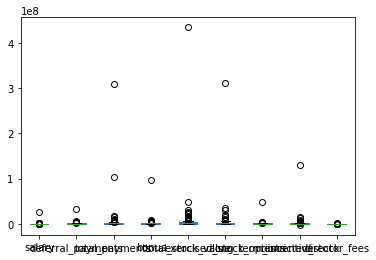

In [9]:
### Task 2: Remove outliers

## Visualize outliers in box-plot
data_df[['salary', 'deferral_payments','total_payments',\
         'bonus','total_stock_value', 'exercised_stock_options',\
        'long_term_incentive', 'restricted_stock', 'director_fees',]].plot.box()


In [10]:
## identify observations that contains outlier 
print 'Detect outliers...'
data_df[['total_stock_value', 'total_payments', 'restricted_stock']].describe()

Detect outliers...


,total_stock_value,total_payments,restricted_stock
count,1.260000e+02,1.250000e+02,1.100000e+02
mean,6.773957e+06,5.081526e+06,2.321741e+06
std,3.895777e+07,2.906172e+07,1.251828e+07
min,-4.409300e+04,1.480000e+02,-2.604490e+06
25%,4.945102e+05,3.944750e+05,2.540180e+05
50%,1.102872e+06,1.101393e+06,4.517400e+05
75%,2.949847e+06,2.093263e+06,1.002370e+06
max,4.345095e+08,3.098866e+08,1.303223e+08


In [11]:
### Check obvious outlier in 'total_stock_values'
### Found observation named 'TOTAL' 

data_df[data_df['total_stock_value']>200000000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
TOTAL,26704229.0,NaN,32083396.0,309886585.0,311764000.0,97343619.0,130322299.0,NaN,-7576788.0,434509511.0,5235198.0,83925000.0,NaN,42667589.0,NaN,False,1398517.0,-27992891.0,48521928.0,NaN


In [12]:
# Check the abnormal observations has negative total stock value
data_df[data_df['total_stock_value']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
BELFER ROBERT,NaN,NaN,-102500.0,102500.0,3285.0,NaN,NaN,NaN,44093.0,-44093.0,NaN,NaN,NaN,NaN,NaN,False,3285.0,NaN,NaN,NaN


In [13]:
# Check the abnormal observations has negative restricted_stock
data_df[data_df['restricted_stock']<0]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
BHATNAGAR SANJAY,NaN,523.0,NaN,15456290.0,2604490.0,NaN,-2604490.0,463.0,15456290.0,NaN,NaN,NaN,29.0,137864.0,1.0,False,137864.0,NaN,NaN,0.0


In [14]:
### Data Cleaning 

print 'Data Cleaning...'
### Remove the row with errors
data_df.drop(['TOTAL','BELFER ROBERT','BHATNAGAR SANJAY',\
              'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E'], inplace=True)


Data Cleaning...


In [15]:
### Fill missing value with 0
data_df=data_df.fillna(0)

In [16]:
### Task 3: Create new feature(s)

print 'Creating new features...'
data_df['to_poi_fraction']=data_df['from_this_person_to_poi']/data_df['from_messages']
data_df['from_poi_fraction']=data_df['from_poi_to_this_person']/data_df['to_messages']
data_df=data_df.fillna(0)


Creating new features...


In [63]:
### update the features_list by adding two new features
features_list_original = ['poi','salary', 'deferral_payments',\
                 'total_payments', 'loan_advances', 'bonus',\
                 'restricted_stock_deferred', 'deferred_income',\
                 'total_stock_value', 'expenses', 'exercised_stock_options',\
                 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',\
                'to_messages', 'from_poi_to_this_person',\
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

features_list_new = ['poi','salary', 'deferral_payments',
                 'total_payments', 'loan_advances', 'bonus',
                 'restricted_stock_deferred', 'deferred_income',
                 'total_stock_value', 'expenses', 'exercised_stock_options',
                 'other', 'long_term_incentive', 'restricted_stock', 'director_fees',
                'to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi',
                'to_poi_fraction','from_poi_fraction'] 

In [44]:
print 'Data formating for sk-learn...'
data_dict_original=data_df.iloc[:, 0:20].to_dict(orient='index')
data_dict_new=data_df.to_dict(orient='index')

Data formating for sk-learn...


In [64]:
features_list=features_list_new
#features_list=features_list_original

In [58]:
### Store to my_dataset for easy export below.

my_dataset = data_dict_new

### Uncomment to see the analysis using original dataset without
### adding new features

#my_dataset = data_dict_original


### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

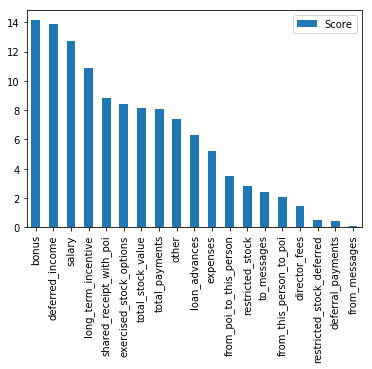

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector=SelectKBest(f_classif, 'all')
scores=selector.fit(features_train, labels_train).scores_

scores_dict={}
for i in range (0, len(scores)):
    feature_name=features_list[i+1]
    score=scores[i]
    scores_dict[feature_name]=score
scores_df=pd.DataFrame.from_dict(scores_dict, orient='index')
scores_df.columns=['Score']
scores_df.sort_values(['Score'], ascending=False).plot(kind='bar')

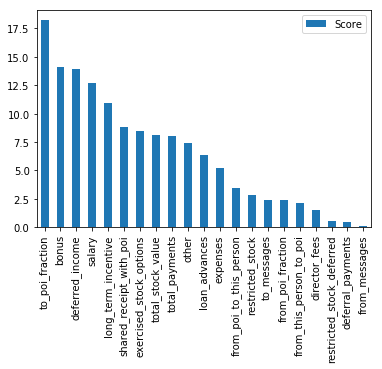

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector=SelectKBest(f_classif, 'all')
scores=selector.fit(features_train, labels_train).scores_

scores_dict={}
for i in range (0, len(scores)):
    feature_name=features_list[i+1]
    score=scores[i]
    scores_dict[feature_name]=score
scores_df=pd.DataFrame.from_dict(scores_dict, orient='index')
scores_df.columns=['Score']
scores_df.sort_values(['Score'], ascending=False).plot(kind='bar')

In [20]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

In [46]:
### Classifier_1 Gaussian Naive Bayes
print 'Gaussian Naive Bayes Classifier...grid searching...'

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV

clf=NB_pipeline()
Params=NB_Params() 
grid_searcher = GridSearchCV(clf, param_grid=Params, cv=10, scoring='f1')
grid_searcher.fit(features_train, labels_train)

print 'The f1 score from Naive Bayes model is:', grid_searcher.best_score_
result_df=pd.DataFrame.from_dict(grid_searcher.cv_results_)
pd.DataFrame.from_dict(grid_searcher.best_params_, orient='index') 


Gaussian Naive Bayes Classifier...grid searching...
The f1 score from Naive Bayes model is: 0.248299319728


,0
selection__k,13


In [47]:
### Final Naive Bayes Classifier
NB_clf=Pipeline([
    ('selection', SelectKBest(f_classif, k=13)),
    ('classification', GaussianNB())
])

In [48]:
### Classifier_2 Decision Tree
print 'Decision Tree Classifier...grid searching...'
from sklearn import tree
from sklearn.model_selection import GridSearchCV


clf=Tree_pipeline()
Params=Tree_Params() 
grid_searcher = GridSearchCV(clf, param_grid=Params, cv=10, scoring='f1')
grid_searcher.fit(features_train, labels_train)

print 'The f1 score from Decision Tree model is:', grid_searcher.best_score_
result_df=pd.DataFrame.from_dict(grid_searcher.cv_results_)
pd.DataFrame.from_dict(grid_searcher.best_params_, orient='index') 


Decision Tree Classifier...grid searching...
The f1 score from Decision Tree model is: 0.39693877551


,0
classification__max_features,log2
selection__k,9
classification__min_samples_split,6
classification__criterion,entropy


In [50]:
### Final tree model (with new features)
Tree_clf = Pipeline([
  ('selection', SelectKBest(f_classif, k=9)),
  ('classification', tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=6, random_state=42, max_features='log2'))
])


In [59]:
### Classifier_3 SVC
print 'SVC Classifier...grid searching...'
from sklearn.svm import SVC
from sklearn import preprocessing


clf=SVC_pipeline()
Params=SVC_Params()
grid_searcher = GridSearchCV(clf, param_grid=Params, cv=10, scoring='f1')
grid_searcher.fit(features_train, labels_train)

print 'The f1 score for SVC classifier is:', grid_searcher.best_score_

result_df=pd.DataFrame.from_dict(grid_searcher.cv_results_)
pd.DataFrame.from_dict(grid_searcher.best_params_, orient='index') 


SVC Classifier...grid searching...
The f1 score for SVC classifier is: 0.215986394558


,0
classification__gamma,100
classification__kernel,poly
classification__C,0.1
selection__k,7


In [60]:
### Final SVC model

SVC_clf=Pipeline([
    ('scaler', preprocessing.MinMaxScaler()),
    ('selection', SelectKBest(f_classif, k=7)),
    ('classification', SVC(kernel='poly', gamma=100, C=0.1, random_state=42) )
])


In [37]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


In [65]:
### Compare three models
print 'models comparing...'
NB_clf.fit(features_train,labels_train)
Tree_clf.fit(features_train,labels_train)
SVC_clf.fit(features_train,labels_train)


classifers_list=[NB_clf,Tree_clf,SVC_clf]
classifer_name_list=['Gaussian Naive Bayes','Decision Tree', 'SVC']

clf_scores={}
for ii in range(0, len(classifers_list)):
    classifier=classifers_list[ii]
    classifer_name=classifer_name_list[ii]
    pred=classifier.predict(features_test)
    scores=accuracy_check(pred, labels_test)
    scores_dict={'Accuracy': scores[0], 'Precision': scores[1],\
     'Recall':scores[2], 'f1':scores[3], 'f2':scores[4]}
    clf_scores[classifer_name]=scores_dict
print 'clf scores:'
pd.DataFrame.from_dict(clf_scores, orient='index')



models comparing...
clf scores:


,f1,Recall,f2,Precision,Accuracy
Decision Tree,0.363636,0.50,0.434783,0.285714,0.837209
Gaussian Naive Bayes,0.444444,0.50,0.476190,0.400000,0.883721
SVC,0.250000,0.25,0.250000,0.250000,0.860465


In [66]:

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.


print 'Validataion...'

clf=Tree_clf
###Uncomment to see results for other classifiers
#clf=NB_clf
#clf=SVC_clf

support=clf.named_steps['selection'].get_support()
features_list=list(np.array(features_list[1:])[support])
features_list=['poi']+features_list

dump_classifier_and_data(clf, my_dataset, features_list)

Validataion...


In [67]:
### Features importances
scores=clf.named_steps['classification'].feature_importances_

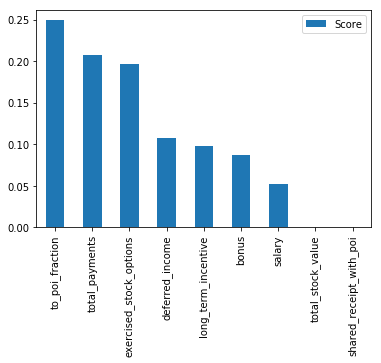

In [68]:
scores_dict={}
for i in range (0, len(scores)):
    feature_name=features_list[i+1]
    score=scores[i]
    scores_dict[feature_name]=score
scores_df=pd.DataFrame.from_dict(scores_dict, orient='index')
scores_df.columns=['Score']
scores_df.sort_values(['Score'], ascending=False).plot(kind='bar')

In [69]:
print 'Final features list'
features_list

['poi',
 'salary',
 'total_payments',
 'bonus',
 'deferred_income',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'to_poi_fraction']